#### Agent: 


1.   Policy - determine action depending on action value
2.   Action - buy, hold, sell


#### Environment: 


1.   Reward - profit or loss 
2.   Features - movement prediction, price difference, number of days holding commodity





#### Setting Up

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving rl.csv to rl.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

import os, shutil
from datetime import datetime
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler

#### Creating Your Own Environment


##### LSTM Model

In [ ]:
df = pd.read_csv('rl.csv') # already normalised dataset
df.set_index('Date', inplace=True)
dataset = df.fillna(-1).values

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

TRAIN_SPLIT = 2798
past_history = 60
future_target = 10
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:,0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:,0], 
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

BATCH_SIZE = 32
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.shuffle(1000).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

# Train a LSTM model outside of the agent
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.MeanSquaredError()

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Masking(mask_value=-1, input_shape=x_train_multi.shape[-2:]), #to handle missing data
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(10)
])

lstm_model.compile(optimizer=optimizer, loss=loss)
lstm_model.fit(train_data_multi, epochs=10, steps_per_epoch=500, validation_data=val_data_multi, validation_steps=50)

Epoch 1/10
500/500 [==============================] - 8s 17ms/step - loss: 0.0517 - val_loss: 0.0102
Epoch 2/10
500/500 [==============================] - 7s 13ms/step - loss: 0.0041 - val_loss: 0.0062
Epoch 3/10
500/500 [==============================] - 7s 13ms/step - loss: 0.0029 - val_loss: 0.0052
Epoch 4/10
500/500 [==============================] - 7s 13ms/step - loss: 0.0025 - val_loss: 0.0047
Epoch 5/10
500/500 [==============================] - 7s 13ms/step - loss: 0.0023 - val_loss: 0.0043
Epoch 6/10
500/500 [==============================] - 6s 13ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 7/10
500/500 [==============================] - 7s 13ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 8/10
500/500 [==============================] - 7s 13ms/step - loss: 0.0019 - val_loss: 0.0036
Epoch 9/10
500/500 [==============================] - 6s 13ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 10/10
500/500 [==============================] - 7s 13ms/step - loss: 0.0017 - val_lo

##### Save LSTM Model

In [ ]:
lstm_model.save("lstm_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: lstm_model/assets


In [ ]:
%%bash
cp -r lstm_model gdrive/My\ Drive/

##### Load LSTM Model

In [ ]:
# load model
%%bash
cp -r gdrive/My\ Drive/lstm_model lstm_model

In [ ]:
lstm_model = tf.keras.models.load_model('lstm_model')

##### Environment

In [ ]:
class TradingEnvironment():

  def state(self, date, history_size): 
    # helper function
    # return state based on history size
    end_index = np.where(self.dataset == date)[0][0]
    start_index = end_index - history_size

    # to be inclusive of current date
    # to remove the date column
    data = self.dataset[range(start_index+1, end_index+1)][:,1:3]
    data = np.array(data, dtype='float')
    data = np.reshape(data, (1,data.shape[0],data.shape[1])) # reshape as lstm model needs to be fitted with 3D data
    data = lstm_model.predict(data)

    # to add price difference and number of days holding commodity as a feature
    self.today_price = data[-1][0]
    if self.buy_price != None:
      difference = data[-1][0] - self.buy_price # current day price minus buy price
      a = datetime.strptime(self.date, '%Y-%m-%d').date()
      b = datetime.strptime(self.buy_date, '%Y-%m-%d').date()
      day_hold = (a-b).days 
    else: 
      difference = 0
      day_hold = 0
    
    data = np.append(data, difference)
    data = np.append(data, day_hold)
    data = np.array([data])

    return data

  def env_init(self, env_info):
    # initialise environment
    # env_info is the environment info containing mode and filename

    reward = None
    state = None
    self.forced_sell = False
    self.total_reward = 0 # scaled profit
    self.total_actual_reward = 0 # actual profit earned
    self.reward_state = (reward, state) # create a tuple to store the reward and state values
    mode = env_info['mode']
    csv = env_info['csv'] # csv is the fileaname containing features date, mpob and sentiment

    self.df = pd.read_csv(csv)

    # scale data values
    self.scaler = MinMaxScaler()
    mpob_data = np.array(self.df['mpob']).reshape(-1,1)
    self.scaler.fit(mpob_data)
    self.df['mpob'] = self.scaler.transform(mpob_data)

    self.df = self.df.fillna(-1)
    self.dataset = self.df.values
    self.date_list = self.df['Date'].values
    self.df = self.df.set_index('Date')

    if mode == 'train': 
      self.date_count = 60
      self.terminate_date = '2019-07-10'
    elif mode == 'test':
      self.date_count = 2798
      self.terminate_date = '2020-07-10'
    else: 
      raise Exception("Can only take train or test mode!")

    self.terminate = False

    # keeps a memory of today price, buy price and buy date
    self.today_price = None
    self.buy_price = None
    self.buy_date = None

    # keeps a current record of current date
    self.date = None

  def env_start(self):
    # the first method called when the trading starts, called before the agent starts.
    reward = 0
    self.date = self.date_list[self.date_count]
    state = self.state(self.date, 60) # history size of 60
    self.reward_state = (reward, state)

  def env_step(self, action):
    # step taken by the environment

    if action == 0: # BUY
      self.buy_price = self.df.loc[self.date]['mpob']
      self.buy_date = self.date
      reward = 0
      actual_reward = 0

    elif action == 1: # HOLD
      if self.buy_date != None: 
        a = datetime.strptime(self.date, '%Y-%m-%d').date()
        b = datetime.strptime(self.buy_date, '%Y-%m-%d').date()
        if (a-b).days >= 90: # maximum number of days holding the commodity
          reward = - 5
          actual_reward = -5000
          self.buy_price = None
          self.buy_date = None
          self.forced_sell = True
          print('Forced to sell!')
        else:
          reward = 0
          actual_reward = 0
      else: 
        reward = 0
        actual_reward = 0
        
    elif action == 2: # SELL
      actual_sell_price = self.scaler.inverse_transform(np.reshape(self.df.loc[self.date]['mpob'], (1,-1)))[0][0] # added
      actual_buy_price = self.scaler.inverse_transform(np.reshape(self.buy_price, (1,-1)))[0][0] # added
      actual_reward = actual_sell_price - actual_buy_price # added

      reward = self.df.loc[self.date]['mpob'] - self.buy_price
      self.buy_price = None
      self.buy_date = None
        
    else: 
      raise Exception(str(action) + " not in recognized actions [0: BUY, 1: HOLD, 2: SELL]!")

    # increment date
    self.date_count = self.date_count + 1
    self.date = self.date_list[self.date_count]
    if self.date == self.terminate_date:
      self.terminate = True
    self.reward_state = (reward, self.state(self.date, 60))
    self.total_reward = self.total_reward + reward
    self.total_actual_reward = self.total_actual_reward + actual_reward
  
  def env_end(self, action):
    if action == 0: # BUY
      self.buy_price = self.df.loc[self.date]['mpob']
      self.buy_date = self.date
      reward = 0
      actual_reward = 0

    elif action == 1: # HOLD
      if self.buy_date != None: 
        a = datetime.strptime(self.date, '%Y-%m-%d').date()
        b = datetime.strptime(self.buy_date, '%Y-%m-%d').date()
        if (a-b).days >= 90: # maximum number of days holding the commodity
          reward = -5
          actual_reward = -5000
          self.buy_price = None
          self.buy_date = None
          self.forced_sell = True
          print('Forced to sell!')
        else:
          reward = 0
          actual_reward = 0
      else: 
        reward = 0
        actual_reward = 0
        
    elif action == 2: # SELL
      actual_sell_price = self.scaler.inverse_transform(np.reshape(self.df.loc[self.date]['mpob'], (1,-1)))[0][0] # added
      actual_buy_price = self.scaler.inverse_transform(np.reshape(self.buy_price, (1,-1)))[0][0] # added
      actual_reward = actual_sell_price - actual_buy_price # added

      reward = self.df.loc[self.date]['mpob'] - self.buy_price
      self.buy_price = None
      self.buy_date = None
        
    else: 
      raise Exception(str(action) + " not in recognized actions [0: BUY, 1: HOLD, 2: SELL]!")
    
    # no need to increment date anymore
    self.reward_state = (reward, None)
    self.total_reward = self.total_reward + reward
    self.total_actual_reward = self.total_actual_reward + actual_reward

#### Agent Implementation

In [ ]:
class TradingAgent():
  def __init__(self):
    self.name = "trading_agent"
    pass

  def agent_init(self, agent_init_info):
    # info related to agent stored in agent_init_info
    self.num_actions = 3 # BUY, HOLD, SELL 
    self.holding = False # not holding any investment in the beginning
    self.epsilon = agent_init_info["epsilon"] # exploration probability
    self.discount = agent_init_info["discount"] # discount factor of reward
    self.rand_generator = np.random.RandomState(agent_init_info["seed"])
    self.mode = agent_init_info['mode']
    resume = agent_init_info['resume']

    if resume: # load from previously halfway trained model
      self.model = tf.keras.models.load_model('rl_dqn_model')
      # slow down learning rate in later stage of training to prevent overfiting
      optimizer = tf.keras.optimizers.Adam(learning_rate=3e-04, epsilon=1e-08, clipnorm=1.0) 
      loss = tf.keras.losses.MeanSquaredError()
      self.model.compile(loss=loss, optimizer=optimizer)
    else: # new model
      # neural network model for action value approximation
      optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, epsilon=1e-08, clipnorm=1.0)
      loss = tf.keras.losses.MeanSquaredError()
      model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, input_dim=12, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dense(3, activation="linear")
      ])
      model.compile(loss=loss, optimizer=optimizer)
      self.model = model

  def agent_take_action(self, act_values):
    # act_values is an array with dimension 3 containing action values for each action
    # agent chooses available action
    if self.rand_generator.rand() < self.epsilon: # random action due to exploration
      if self.holding:
        action = self.rand_generator.randint(2) + 1 # buying action not available
      else: 
        action = self.rand_generator.randint(2) # selling action not available
    else:
      if self.holding:
        action = self.argmax(act_values[1:3]) + 1 # buying action not available
      else: 
        action = self.argmax(act_values[0:2]) # selling action not available
    return action

  def agent_start(self, state):
    # first action taken by the agent
    # input state value into model, action value return is an array with dimension 3
    self.holding = False
    act_values = self.model.predict(state)[0]
    action = self.agent_take_action(act_values)
    self.prev_state = state
    self.prev_action = action

    if action == 0:
      self.holding = True
    elif action == 2: 
      self.holding = False
    
    # initialise with arbituary values
    self.memory_data = np.ones((1,12))-2
    self.memory_target =  np.array([[0,0,0]])

    return action
    
  def agent_step(self, reward, state):
    # reward (r.t) is the reward obtained from the previous step, state (s.t+1) is the state for the current step
    # subsequent actions by agent
    act_values = self.model.predict(state)[0]
    action = self.agent_take_action(act_values)
        
    # Perform an update to the neural network model based on previous step
    target = reward + self.discount * act_values[action] 
    target_f = self.model.predict(self.prev_state) # action values of previous step
    target_f[0][self.prev_action] = target
    
    # instead of fitting every step, keep it in a memory first
    self.memory_data = np.vstack((self.memory_data, self.prev_state))
    self.memory_target = np.vstack((self.memory_target, target_f))

    self.prev_state = state
    self.prev_action = action 

    if action == 0:
      self.holding = True
    elif action == 2: 
      self.holding = False

    return action
    
  def agent_end(self, reward):
    # Perform the last update 
    target = reward
    target_f = self.model.predict(self.prev_state) # action values of previous step
    target_f[0][self.prev_action] = target

    # store in memory for the last time
    self.memory_data = np.vstack((self.memory_data, self.prev_state))
    self.memory_target = np.vstack((self.memory_target, target_f))

    # update the model if in training mode
    if self.mode == 'train':
      train_data = tf.data.Dataset.from_tensor_slices((self.memory_data, self.memory_target))
      train_data = train_data.shuffle(1000).batch(32).repeat()
      self.model.fit(train_data, epochs=1, verbose=1, steps_per_epoch=100)
      # self.model.fit(self.memory_data, self.memory_target, epochs=1, verbose=1)

  def argmax(self, state):
    # return the highest action value
    # randomly choose if action values are tied
    top = float("-inf")
    ties = []
    for i in range(len(state)):
      if state[i] > top:
        top = state[i]
        ties = []

      if state[i] == top:
        ties.append(i)

    return self.rand_generator.choice(ties)

#### Train the agent

In [ ]:
# Configurations
agent_init_info = {'epsilon':0.20,
                  'discount':0.99,
                  'seed':20,
                  'mode':'train',
                  'resume': True}
env_info = {'mode':'train',
            'csv':'rl.csv'}
num_episodes = 10

# Actual training
episodes = []
total_earnings = []
agent = TradingAgent()
agent.agent_init(agent_init_info)
for episode in tqdm(range(num_episodes)):
  env = TradingEnvironment()
  env.env_init(env_info)
  env.env_start()
  state = env.reward_state[1]
  action = agent.agent_start(state)
  while True:
    env.env_step(action)
    reward = env.reward_state[0]
    state = env.reward_state[1]
    if env.forced_sell:
      print(env.date)
      agent.holding = False
      env.forced_sell = False
    action = agent.agent_step(reward,state)
    if env.terminate:
      env.env_end(action)
      reward = env.reward_state[0]
      agent.agent_end(reward)
      break
  print('Total reward in episode ', episode, ' is ', env.total_reward)
  print('Total actual reward in episode ', episode, ' is ', env.total_actual_reward)
  episodes.append(episode)
  total_earnings.append(env.total_reward)

100/100 [==============================] - 0s 2ms/step - loss: 1.4207e-05
Total reward in episode  0  is  0.32497748964523576
Total actual reward in episode  0  is  902.299999999995
100/100 [==============================] - 0s 2ms/step - loss: 1.3593e-05
Total reward in episode  1  is  -0.15955339456149797
Total actual reward in episode  1  is  -442.9999999999993
100/100 [==============================] - 0s 2ms/step - loss: 1.1868e-05
Total reward in episode  2  is  0.13992436520799478
Total actual reward in episode  2  is  388.4999999999984
100/100 [==============================] - 0s 2ms/step - loss: 9.6616e-06
Total reward in episode  3  is  0.6032775076535206
Total actual reward in episode  3  is  1675.0000000000007
100/100 [==============================] - 0s 2ms/step - loss: 1.2324e-05
Total reward in episode  4  is  0.20169277867819035
Total actual reward in episode  4  is  559.9999999999945
100/100 [==============================] - 0s 2ms/step - loss: 1.0857e-05
Total rewa

In [ ]:
# Keep a record of episodes and rewards for future plotting
import csv
with open('earnings.csv', 'a', newline='', encoding="utf-8") as writeFile:
  writer = csv.writer(writeFile)
  for earning in total_earnings: 
    writer.writerow([earning])

In [ ]:
files.download('earnings.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Save agent model

In [ ]:
agent.model.save("rl_dqn_model")

INFO:tensorflow:Assets written to: rl_dqn_model/assets


In [ ]:
%%bash
cp -r rl_dqn_model gdrive/My\ Drive/

##### Load Agent and Resume Training

In [ ]:
%%bash
cp -r gdrive/My\ Drive/rl_dqn_model rl_dqn_model

##### Figures:

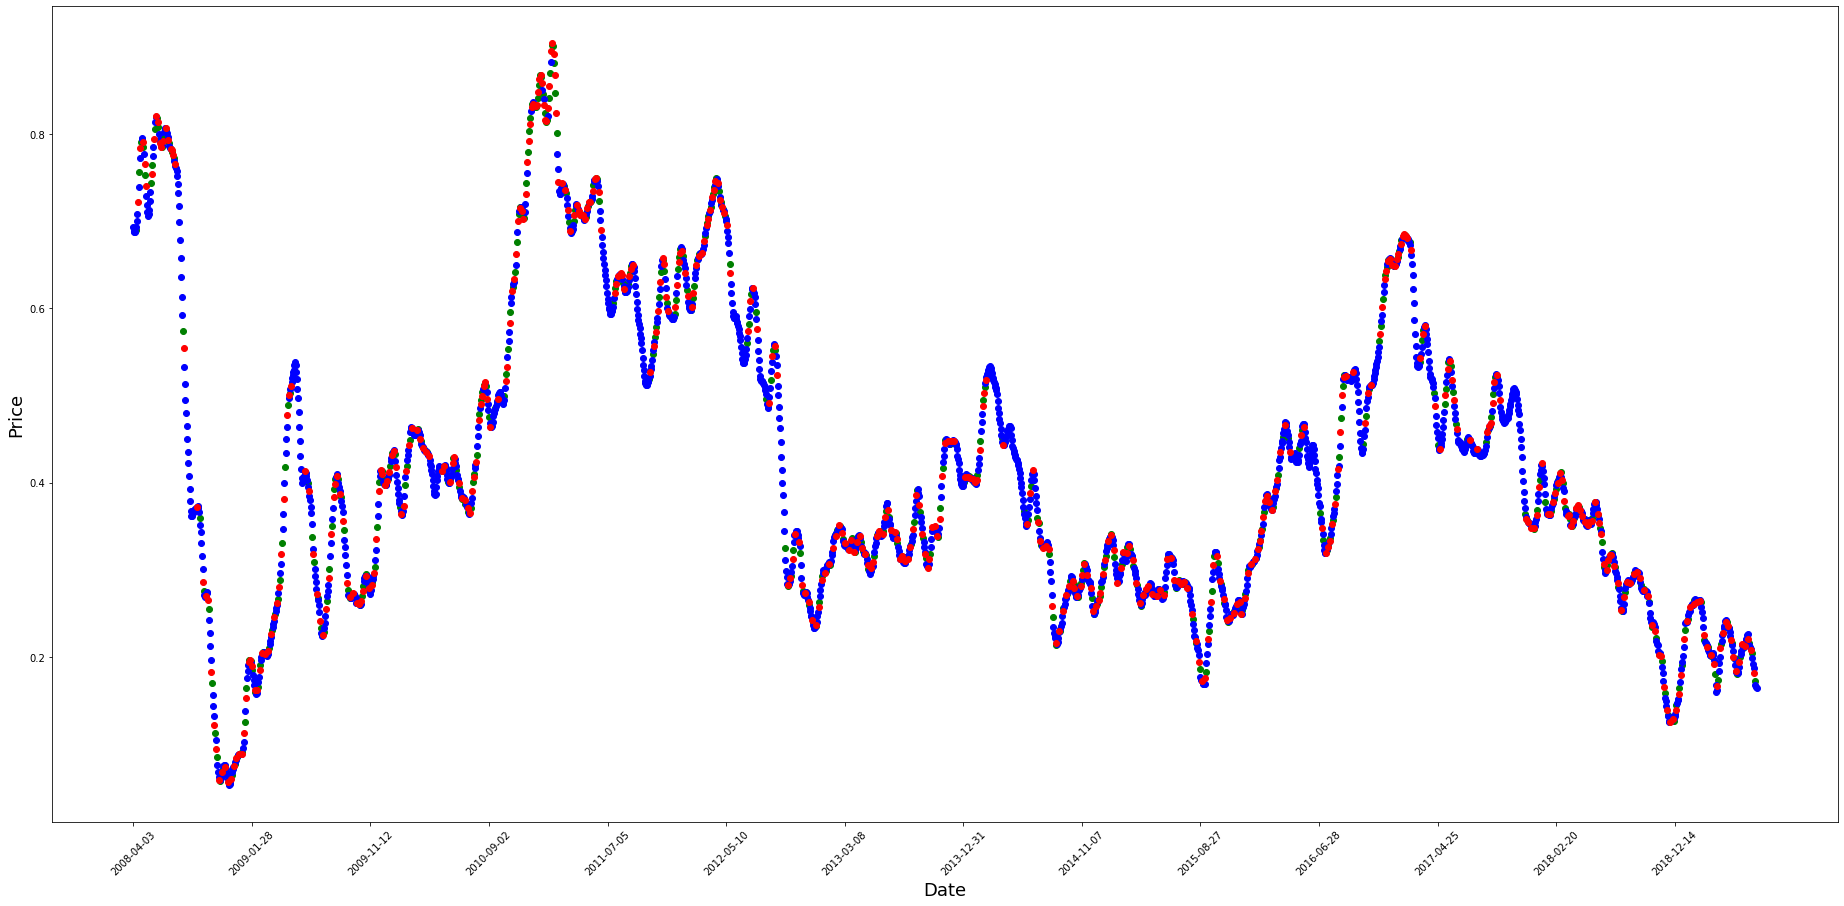

In [ ]:
temp = np.arange(len(dates))
prices = np.array(today_prices)
mask_buy = np.array([item==0 for item in actions_taken])
mask_hold = np.array([item==1 for item in actions_taken])
mask_sell = np.array([item==2 for item in actions_taken])
prices_buy = prices[mask_buy]
prices_hold = prices[mask_hold]
prices_sell = prices[mask_sell]
dates_buy = temp[mask_buy]
dates_hold = temp[mask_hold]
dates_sell = temp[mask_sell]

# Plot to see the actions taken during training
plt.figure(figsize = (32,15))
plt.scatter(dates_buy, prices_buy, c='g', marker="o")
plt.scatter(dates_hold, prices_hold, c='b', marker="o")
plt.scatter(dates_sell, prices_sell, c='r', marker="o")
plt.xticks(range(0,len(dates),200),dates[::200],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.show()

##### Evaluate on test data

In [ ]:
# Configurations
agent_init_info = {'epsilon':0.02,
                  'discount':0.99,
                  'seed':20,
                  'mode':'test',
                  'resume': True}
env_info = {'mode':'test',
            'csv':'rl.csv'}

today_prices = []
dates = []
actions_taken = []

# initialise agent
agent = TradingAgent()
agent.agent_init(agent_init_info)

# initialise environment
env = TradingEnvironment()
env.env_init(env_info)
env.env_start()
  
dates.append(env.date) # added 
today_prices.append(env.today_price) # added 
state = env.reward_state[1]
action = agent.agent_start(state)
actions_taken.append(action) # added 
while True:
  env.env_step(action)
  dates.append(env.date) # added 
  today_prices.append(env.today_price) # added 
  reward = env.reward_state[0]
  state = env.reward_state[1]
  if env.forced_sell:
    agent.holding = False
    env.forced_sell = False
  action = agent.agent_step(reward,state)
  actions_taken.append(action) # added 
  if env.terminate:
    env.env_end(action)
    reward = env.reward_state[0]
    agent.agent_end(reward)
    break
print('Total reward is ', env.total_reward)
print('Total actual reward is ', env.total_actual_reward)

Total reward is  0
Total actual reward is  0


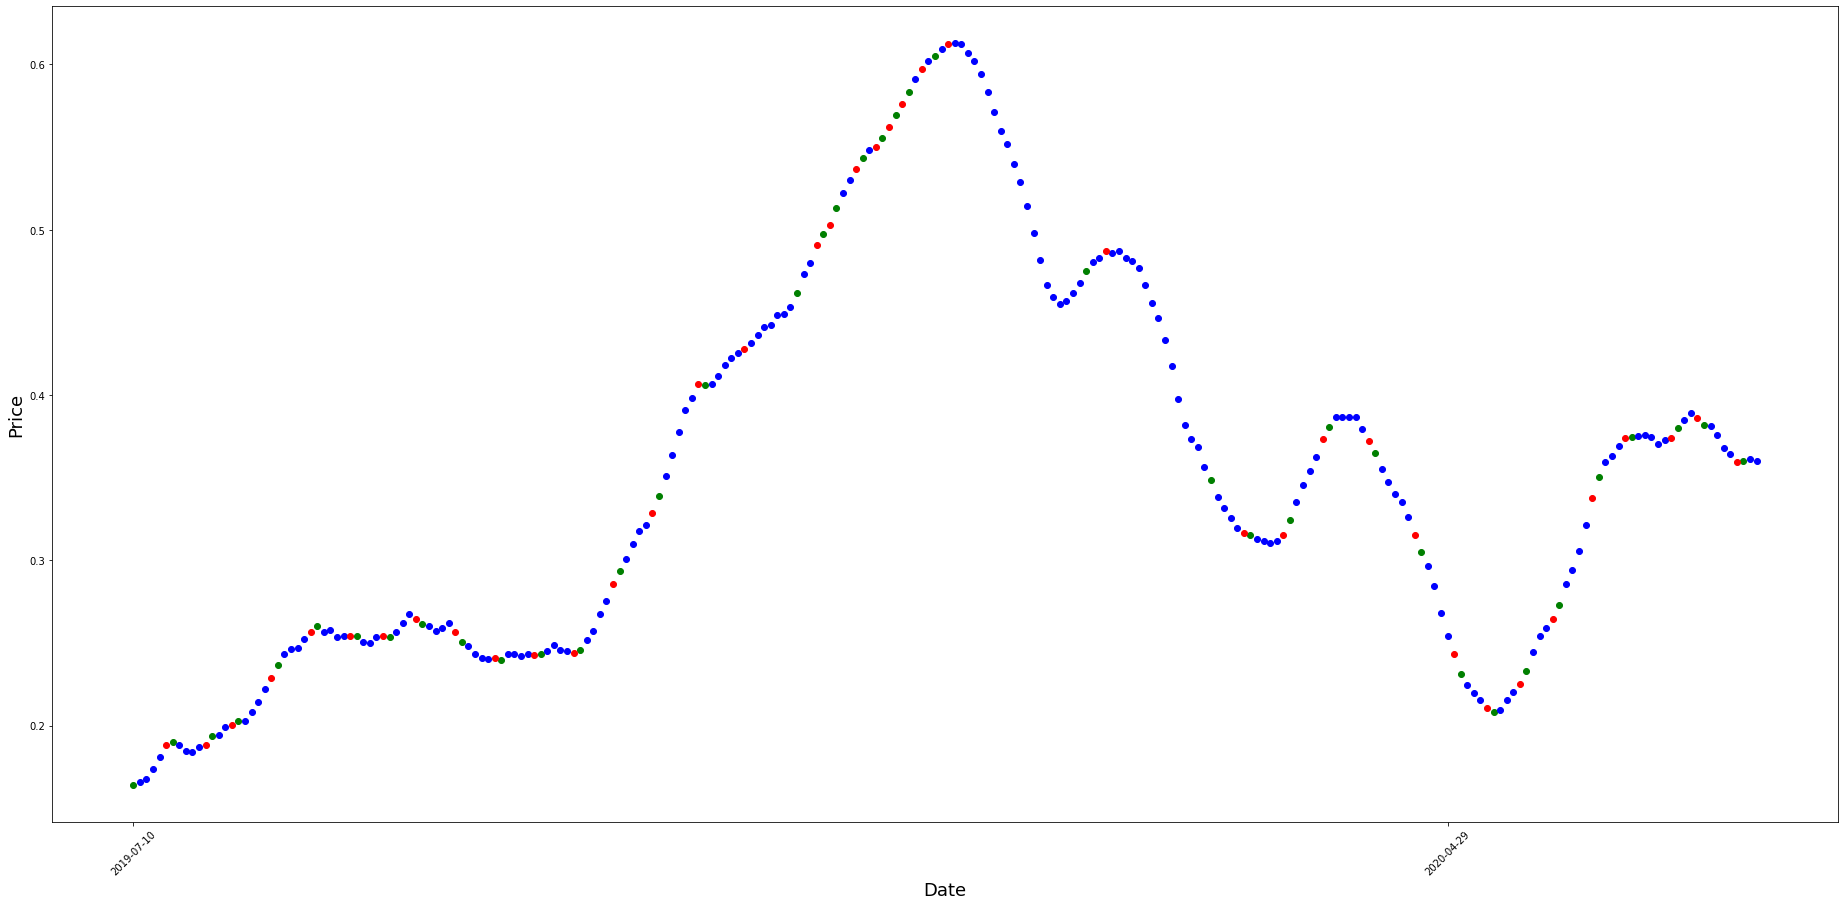

In [ ]:
temp = np.arange(len(dates))
prices = np.array(today_prices)
mask_buy = np.array([item==0 for item in actions_taken])
mask_hold = np.array([item==1 for item in actions_taken])
mask_sell = np.array([item==2 for item in actions_taken])
prices_buy = prices[mask_buy]
prices_hold = prices[mask_hold]
prices_sell = prices[mask_sell]
dates_buy = temp[mask_buy]
dates_hold = temp[mask_hold]
dates_sell = temp[mask_sell]

# on test set
plt.figure(figsize = (32,15))
plt.scatter(dates_buy, prices_buy, c='g', marker="o") # BUY denoted by green
plt.scatter(dates_hold, prices_hold, c='b', marker="o") # HOLD denoted by blue
plt.scatter(dates_sell, prices_sell, c='r', marker="o") # SELL denoted by red
plt.xticks(range(0,len(dates),200),dates[::200],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.show()

GREEN (BUY) , BLUE (HOLD), RED (SELL)